## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果  
***** 參考文章: [Multi-class classification with focal loss for imbalanced datasets](https://www.dlology.com/blog/multi-class-classification-with-focal-loss-for-imbalanced-datasets/)

In [10]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [11]:
train, test = keras.datasets.cifar10.load_data()

In [12]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [13]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [14]:
from keras.layers import BatchNormalization
"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [27]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(gamma=2., alpha=4., ce_weights=0.7, fcl_weights=0.3):
    """Define the customized loss."""
    """ Focal loss for multi-classification
    FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
    Notice: y_pred is probability after softmax
    gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
    d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
    Focal Loss for Dense Object Detection 
    
    Arguments:
        y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
        y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

    Keyword Arguments:
        gamma {float} -- (default: {2.0})
        alpha {float} -- (default: {4.0})

    Returns:
        [tensor] -- loss.    
    """
    
    gamma = float(gamma)
    alpha = float(alpha)
    
    #再加入
    def CE_focal_loss(y_true, y_pred):
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        ce_loss = keras.losses.categorical_crossentropy(y_true, y_pred)
        return (ce_weights*ce_loss) + (fcl_weights*tf.reduce_mean(reduced_fl))
    return CE_focal_loss
ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [28]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """

    model.compile(loss=combined_loss(ce_weights=ce_w, fcl_weights=1.-ce_w), metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_34 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_35 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_36 (Batc (None, 128) 

Epoch 14/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.9246 - acc: 0.6580 - val_loss: 3.2505 - val_acc: 0.4778
Epoch 15/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.8335 - acc: 0.6721 - val_loss: 3.2321 - val_acc: 0.4878
Epoch 16/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.7484 - acc: 0.6828 - val_loss: 3.2488 - val_acc: 0.4793
Epoch 17/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.6671 - acc: 0.6958 - val_loss: 3.3133 - val_acc: 0.4795
Epoch 18/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.5721 - acc: 0.7112 - val_loss: 3.3143 - val_acc: 0.4866
Epoch 19/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.4945 - acc: 0.7225 - val_loss: 3.4345 - val_acc: 0.4787
Epoch 20/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.4163 - acc: 0.7351 - val_loss: 3.4339 - val_acc: 0.4802
Epoch 21/25
50000/50000 [=========

Epoch 2/25
50000/50000 [==============================] - 5s 90us/step - loss: 2.5761 - acc: 0.4196 - val_loss: 2.9102 - val_acc: 0.3842
Epoch 3/25
50000/50000 [==============================] - 5s 92us/step - loss: 2.3666 - acc: 0.4588 - val_loss: 2.5408 - val_acc: 0.4264
Epoch 4/25
50000/50000 [==============================] - 5s 91us/step - loss: 2.2402 - acc: 0.4831 - val_loss: 2.4404 - val_acc: 0.4447
Epoch 5/25
50000/50000 [==============================] - 5s 91us/step - loss: 2.1387 - acc: 0.5023 - val_loss: 2.3729 - val_acc: 0.4488
Epoch 6/25
50000/50000 [==============================] - 5s 91us/step - loss: 2.0563 - acc: 0.5194 - val_loss: 2.3514 - val_acc: 0.4555
Epoch 7/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.9845 - acc: 0.5350 - val_loss: 2.3048 - val_acc: 0.4642
Epoch 8/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.9180 - acc: 0.5503 - val_loss: 2.2812 - val_acc: 0.4670
Epoch 9/25
50000/50000 [=================

50000/50000 [==============================] - 5s 91us/step - loss: 0.9593 - acc: 0.6760 - val_loss: 1.4532 - val_acc: 0.4973


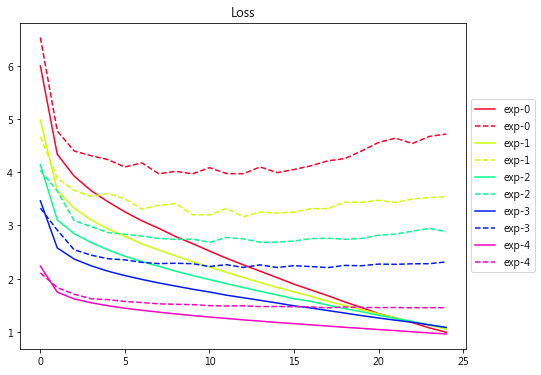

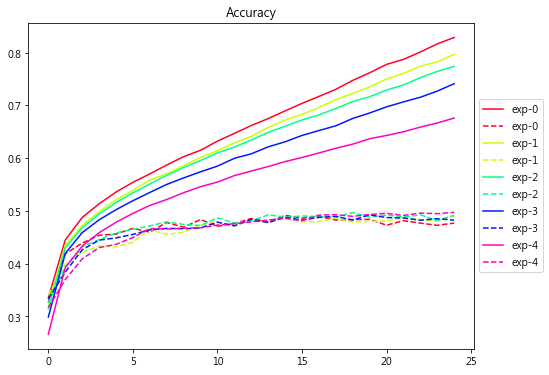

In [29]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()